<h1 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h1>

<h2 style="text-align: center;"><b>Семестр 1 Осень 2025 года. Финальный проект. Geometry ML</b></h2>


**Выполил:** Емельянов Евгений  
**Stepik ID:** https://stepik.org/users/37851967  
**TG:** evg_em

# Предварительные процедуры

## Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import tarfile
import os
from collections import Counter, defaultdict
from node2vec import Node2Vec 
import warnings
from collections import deque
from glob import glob
import community as community_louvain
import gudhi as gd
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from gudhi.representations import PersistenceImage
from matplotlib.patches import Patch
from scipy import stats
warnings.filterwarnings('ignore')

## Загрузка данных

In [2]:
def load_combined(data_dir="facebook_data"):    

    print("Загрузка полного графа")
    G_combined = nx.Graph()    
    with open(os.path.join(data_dir, "facebook_combined.txt"), 'r') as f:
        for line in f:
            if line.strip():
                node1, node2 = map(int, line.strip().split())
                G_combined.add_edge(node1, node2)  
    return G_combined

In [3]:
G_combined = load_combined()

Загрузка полного графа


In [4]:
def load_all_facebook_ego_networks(data_dir="facebook_data"):
   
    print("=" * 70)
    print("ЗАГРУЗКА ВСЕХ EGO-NETWORKS")
    print("=" * 70)
    
    facebook_dir = os.path.join(data_dir)

    edge_files = glob(os.path.join(facebook_dir, "*.edges"))

    print(f"Найдено ego-networks: {len(edge_files)}")
    
    ego_networks = {}
    
    for edge_file in edge_files:
        ego_id = os.path.basename(edge_file).split('.')[0]
        
        print(f"\nЗагрузка ego-network {ego_id}")
        
        ego_data = load_single_ego_network(facebook_dir, ego_id)
        
        if ego_data:
            ego_networks[ego_id] = ego_data
            print(f"  Узлов: {ego_data['graph'].number_of_nodes()}, "
                  f"Рёбер: {ego_data['graph'].number_of_edges()}, "
                  f"Кругов: {len(ego_data['circles'])}")
    
    print(f"\nЗагружено ego-networks: {len(ego_networks)}")
    
    return ego_networks

def load_single_ego_network(data_dir, ego_id):
 
    base_path = os.path.join(data_dir, ego_id)
    
    ego_data = {
        'id': ego_id,
        'graph': None,
        'circles': {},
        'node_features': None,
        'ego_features': None,
        'feat_names': None,
        'node_ids': None
    }
    
    # Загрузка рёбер
    edges_file = f"{base_path}.edges"
    if os.path.exists(edges_file):
        try:
            edges = pd.read_csv(edges_file, sep=' ', header=None, names=['node1', 'node2'])
            ego_data['edges'] = edges
            
            # Строим граф
            G = nx.Graph()
            for _, row in edges.iterrows():
                G.add_edge(row['node1'], row['node2'])

            ego_node = int(ego_id)
            G.add_node(ego_node)
            for friend in edges['node1'].unique():
                if friend != ego_node:
                    G.add_edge(ego_node, friend)
            
            ego_data['graph'] = G
        except Exception as e:
            print(f"  Ошибка загрузки рёбер: {e}")
            return None
    
    # Загрузка кругов
    circles_file = f"{base_path}.circles"
    if os.path.exists(circles_file):
        circles = {}
        try:
            with open(circles_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) > 1:
                        circle_name = parts[0]
                        members = list(map(int, parts[1:]))
                        circles[circle_name] = members
            ego_data['circles'] = circles
        except Exception as e:
            print(f"  Ошибка загрузки кругов: {e}")
    
    # Загрузка фичей узлов
    feat_file = f"{base_path}.feat"
    if os.path.exists(feat_file):
        try:
            node_features_data = np.loadtxt(feat_file)
            if len(node_features_data.shape) == 1:
                node_features_data = node_features_data.reshape(1, -1)
            
            node_ids = node_features_data[:, 0].astype(int)
            node_features = node_features_data[:, 1:]
            
            ego_data['node_features'] = node_features
            ego_data['node_ids'] = node_ids
        except Exception as e:
            print(f"  Ошибка загрузки фичей узлов: {e}")
    
    # Загрузка эго-фичей
    egofeat_file = f"{base_path}.egofeat"
    if os.path.exists(egofeat_file):
        try:
            ego_features = np.loadtxt(egofeat_file)
            ego_data['ego_features'] = ego_features
        except Exception as e:
            print(f"  Ошибка загрузки эго-фичей: {e}")
    
    # Загрузка названий фичей
    featnames_file = f"{base_path}.featnames"
    if os.path.exists(featnames_file):
        try:
            with open(featnames_file, 'r') as f:
                feat_names = []
                for line in f:
                    line = line.strip()
                    if ' ' in line:
                        parts = line.split(' ', 1)
                        feat_names.append(parts[1])
                    else:
                        feat_names.append(line)
            ego_data['feat_names'] = feat_names
        except Exception as e:
            print(f"  Ошибка загрузки названий фичей: {e}")
    
    return ego_data

In [5]:
ego_networks = load_all_facebook_ego_networks()

ЗАГРУЗКА ВСЕХ EGO-NETWORKS
Найдено ego-networks: 10

Загрузка ego-network 0
  Узлов: 334, Рёбер: 2852, Кругов: 24

Загрузка ego-network 107
  Узлов: 1035, Рёбер: 27783, Кругов: 9

Загрузка ego-network 1684
  Узлов: 787, Рёбер: 14810, Кругов: 17

Загрузка ego-network 1912
  Узлов: 748, Рёбер: 30772, Кругов: 46

Загрузка ego-network 3437
  Узлов: 535, Рёбер: 5347, Кругов: 32

Загрузка ego-network 348
  Узлов: 225, Рёбер: 3416, Кругов: 14

Загрузка ego-network 3980
  Узлов: 53, Рёбер: 198, Кругов: 17

Загрузка ego-network 414
  Узлов: 151, Рёбер: 1843, Кругов: 7

Загрузка ego-network 686
  Узлов: 169, Рёбер: 1824, Кругов: 14

Загрузка ego-network 698
  Узлов: 62, Рёбер: 331, Кругов: 13

Загружено ego-networks: 10


# 1. Первичный анализ

## 1.1. Ego-networks: анализ и визуализация

In [6]:
def analyze_all_ego_networks(ego_networks):

    print("\n" + "=" * 70)
    print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ EGO-NETWORKS")
    print("=" * 70)
    
    analysis_results = {}
    
    for ego_id, ego_data in ego_networks.items():
        print(f"\nАнализ ego-network {ego_id}:")
        
        G = ego_data['graph']
       
        metrics = calculate_graph_metrics(G, ego_data)
        analysis_results[ego_id] = metrics
        
        # Вывод основных метрик

        print(f"  Средняя степень: {metrics['avg_degree']:.2f}")
        print(f"  Коэф. кластеризации: {metrics['clustering']:.4f}")
        print(f"  Компонент связности: {metrics['num_components']}")
        print(f"  Плотность графа: {metrics['density']:.4f}")
        print(f"  Ассортативность по степени: {metrics['degree_assortativity']:.4f}")
        
    return analysis_results

def calculate_graph_metrics(G, ego_data):

    metrics = {}
    
    # Основные метрики
    metrics['num_nodes'] = G.number_of_nodes()
    metrics['num_edges'] = G.number_of_edges()

    degrees = [d for n, d in G.degree()]
    metrics['avg_degree'] = np.mean(degrees) if degrees else 0
    metrics['max_degree'] = max(degrees) if degrees else 0
    metrics['min_degree'] = min(degrees) if degrees else 0
    
    metrics['clustering'] = nx.average_clustering(G)

    metrics['num_components'] = nx.number_connected_components(G)
    components = list(nx.connected_components(G))
    metrics['component_sizes'] = [len(c) for c in components]
    metrics['num_circles'] = len(ego_data.get('circles', {}))

    metrics['density'] = nx.density(G) 
    metrics['degree_assortativity'] = nx.degree_assortativity_coefficient(G)

    
    return metrics

In [7]:
analysis_results = analyze_all_ego_networks(ego_networks)


СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ EGO-NETWORKS

Анализ ego-network 0:
  Средняя степень: 17.08
  Коэф. кластеризации: 0.6820
  Компонент связности: 1
  Плотность графа: 0.0513
  Ассортативность по степени: -0.1371

Анализ ego-network 107:
  Средняя степень: 53.69
  Коэф. кластеризации: 0.5817
  Компонент связности: 1
  Плотность графа: 0.0519
  Ассортативность по степени: -0.0226

Анализ ego-network 1684:
  Средняя степень: 37.64
  Коэф. кластеризации: 0.5406
  Компонент связности: 1
  Плотность графа: 0.0479
  Ассортативность по степени: -0.0658

Анализ ego-network 1912:
  Средняя степень: 82.28
  Коэф. кластеризации: 0.6695
  Компонент связности: 1
  Плотность графа: 0.1101
  Ассортативность по степени: 0.1024

Анализ ego-network 3437:
  Средняя степень: 19.99
  Коэф. кластеризации: 0.6388
  Компонент связности: 1
  Плотность графа: 0.0374
  Ассортативность по степени: -0.0909

Анализ ego-network 348:
  Средняя степень: 30.36
  Коэф. кластеризации: 0.6244
  Компонент связности: 1
  Плотност

In [8]:
def visualize_comparative_analysis(analysis_results):

    ego_ids = list(analysis_results.keys())    

    metrics_df = pd.DataFrame([
        {**{'ego_id': ego_id}, **metrics} 
        for ego_id, metrics in analysis_results.items()])
    
    valid_ego_ids = []
    for ego_id in ego_ids:
        if analysis_results[ego_id]['num_nodes'] > 0:
            valid_ego_ids.append(ego_id)    

    
    valid_ego_ids.sort(key=lambda x: analysis_results[x]['num_nodes'])
    

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Количество узлов и рёбер
    ax = axes[0]
    x = range(len(valid_ego_ids))
    width = 0.35
    
    nodes = [analysis_results[eid]['num_nodes'] for eid in valid_ego_ids]
    edges = [analysis_results[eid]['num_edges'] for eid in valid_ego_ids]
    
    bars1 = ax.bar([i - width/2 for i in x], nodes, width, label='Nodes', color='skyblue', alpha=0.8)
    bars2 = ax.bar([i + width/2 for i in x], edges, width, label='Edges', color='lightcoral', alpha=0.8)
    
    ax.set_xlabel('Ego-network')
    ax.set_ylabel('Count')
    ax.set_title('Размер ego-networks (узлы и рёбра)')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_ego_ids, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{int(height)}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=8)
    
    # Средняя степень и кластеризация
    ax = axes[1]
    x = range(len(valid_ego_ids))
    
    avg_degree = [analysis_results[eid]['avg_degree'] for eid in valid_ego_ids]
    clustering = [analysis_results[eid]['clustering'] for eid in valid_ego_ids]
    
    line1 = ax.plot(x, avg_degree, 'o-', label='Avg Degree', color='blue', linewidth=2, markersize=6)
    ax.set_xlabel('Ego-network')
    ax.set_ylabel('Avg Degree', color='blue')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_ego_ids, rotation=45)
    ax.tick_params(axis='y', labelcolor='blue')
    ax.grid(True, alpha=0.3)
    
    ax2 = ax.twinx()
    line2 = ax2.plot(x, clustering, 's-', label='Clustering', color='red', linewidth=2, markersize=6)
    ax2.set_ylabel('Clustering', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left')
    
    ax.set_title('Структурные характеристики')
    
    # Количество кругов
    ax = axes[2]
    num_circles = [analysis_results[eid]['num_circles'] for eid in valid_ego_ids]
    
    bars = ax.bar(x, num_circles, color='lightgreen', alpha=0.8)
    ax.set_xlabel('Ego-network')
    ax.set_ylabel('Count')
    ax.set_title('Circles')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_ego_ids, rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Плотность графа
    ax = axes[3]
    density = [analysis_results[eid]['density'] for eid in valid_ego_ids if 'density' in analysis_results[eid]]
    
    valid_for_density = [eid for eid in valid_ego_ids if 'density' in analysis_results[eid]]
    
    bars = ax.bar(range(len(valid_for_density)), density, color='orange', alpha=0.8)
    ax.set_xlabel('Ego-network')
    ax.set_ylabel('Density')
    ax.set_title('Плотность графа')
    ax.set_xticks(range(len(valid_for_density)))
    ax.set_xticklabels(valid_for_density, rotation=45)
    ax.grid(True, alpha=0.3)

    
    # Ассортативность по степени
    ax = axes[4]
    assortativity = []
    assortativity_ego_ids = []
    
    for eid in valid_ego_ids:
        if ('degree_assortativity' in analysis_results[eid] and 
            analysis_results[eid]['degree_assortativity'] is not None):
            assortativity.append(analysis_results[eid]['degree_assortativity'])
            assortativity_ego_ids.append(eid)
    
    colors = ['green' if a > 0 else 'red' for a in assortativity]
    bars = ax.bar(range(len(assortativity)), assortativity, 
                  color=colors, alpha=0.8)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Ego-network')
    ax.set_ylabel('Assortativity')
    ax.set_title('Ассортативность по степени\n(>0: гомофилия, <0: гетерофилия)')
    ax.set_xticks(range(len(assortativity)))
    ax.set_xticklabels(assortativity_ego_ids, rotation=45)
    ax.grid(True, alpha=0.3)

    
    # Распределение размеров компонент
    ax = axes[5]

    all_component_sizes = []
    for eid in valid_ego_ids[:min(5, len(valid_ego_ids))]:  # Первые 5 для наглядности
        sizes = analysis_results[eid].get('component_sizes', [])
        if sizes:
            all_component_sizes.append(sizes)
    
    bp = ax.boxplot(all_component_sizes, patch_artist=True)
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_component_sizes)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_xlabel('Ego-network')
    ax.set_ylabel('Component Size')
    ax.set_title('Распределение размеров компонент связности')
    ax.set_xticks(range(1, len(all_component_sizes) + 1))
    ax.set_xticklabels(valid_ego_ids[:len(all_component_sizes)], rotation=45)

    
    plt.suptitle('СРАВНИТЕЛЬНЫЙ АНАЛИЗ FACEBOOK EGO-NETWORKS', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return metrics_df


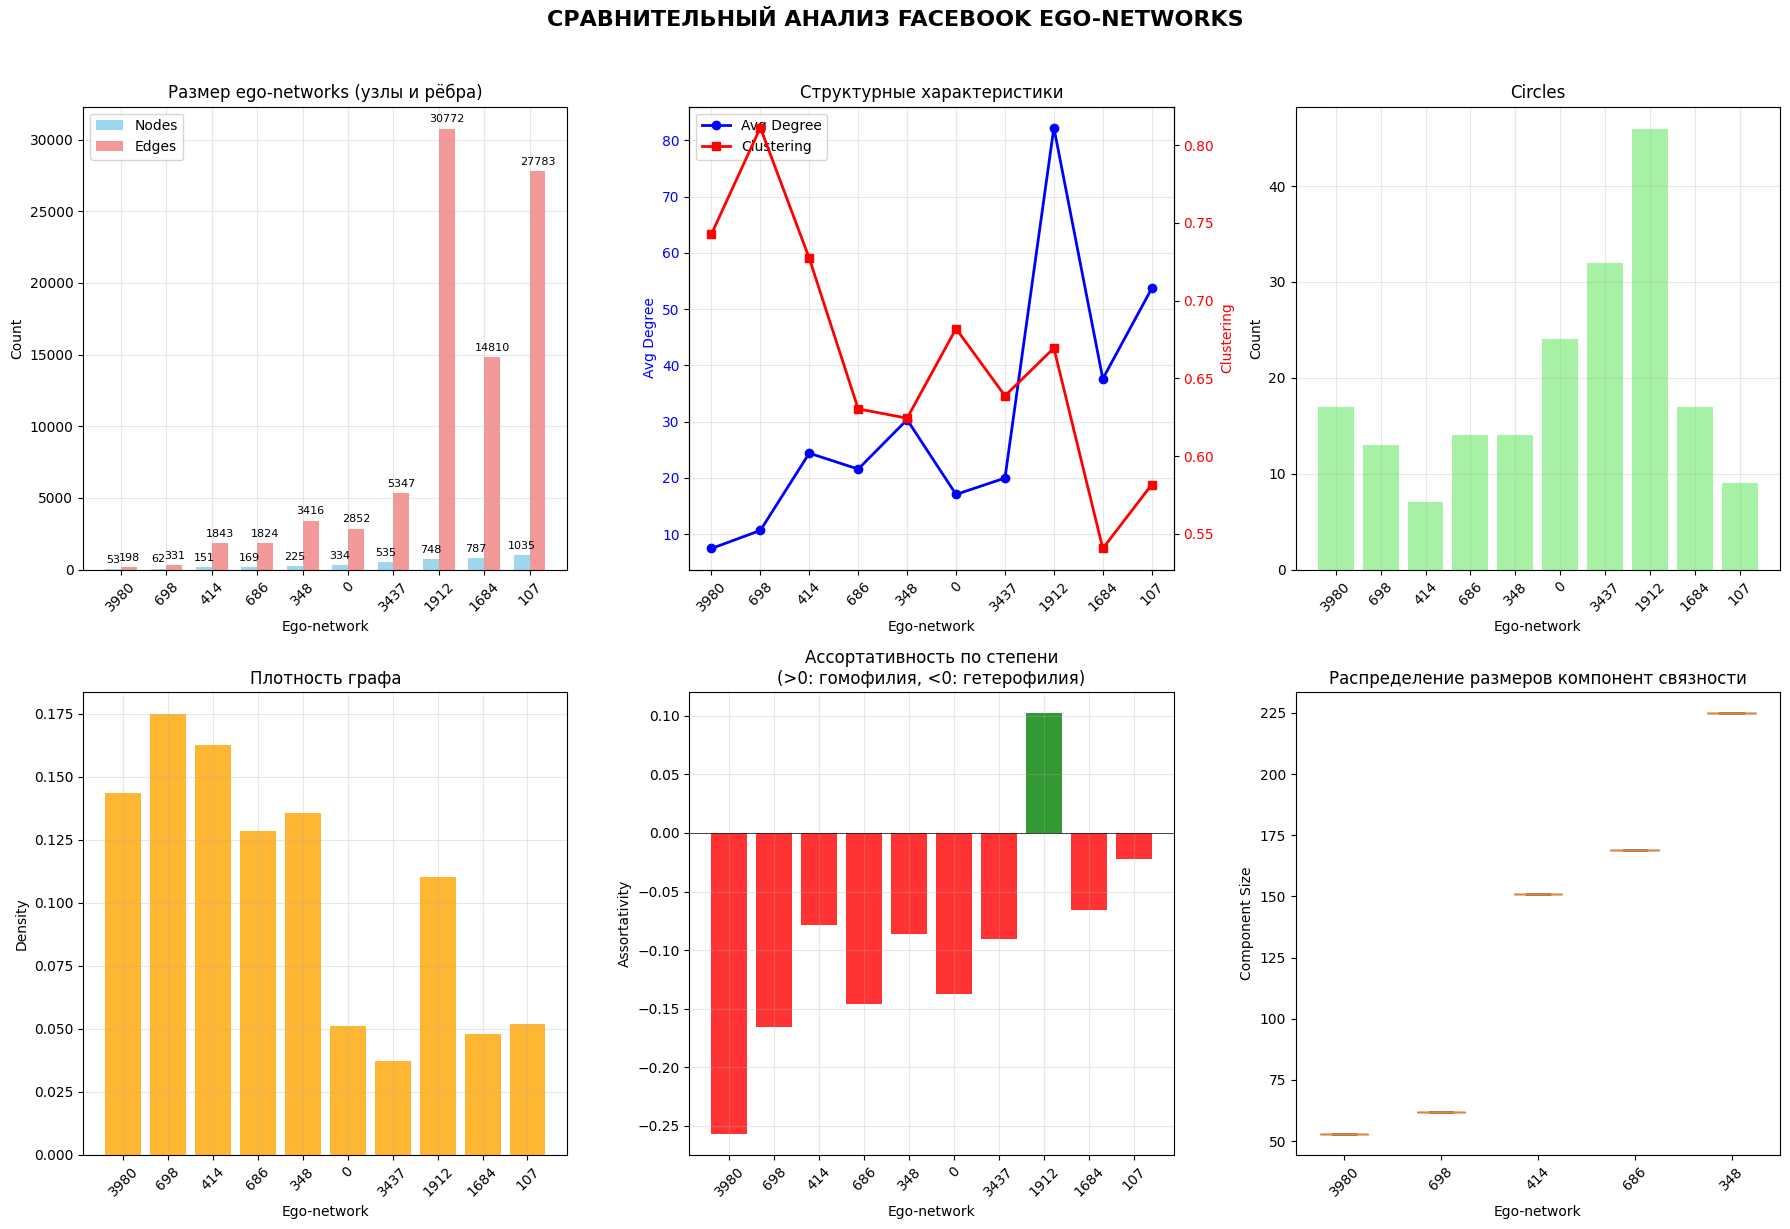

In [9]:
metrics_df = visualize_comparative_analysis(analysis_results)

### Выводы:
1. Все ego-networks показали высокий коэффициент кластеризации (0.54-0.81). Вероятно, данный подтверждает гипотезу транзитивности — друзья одного человека с большой вероятностью дружат между собой
2. Ассортативность по степени в основном отрицательная (8 из 10), что типично для звездообразных структур (тем более что рассматриваются отдельные ego-netwirks с выраженным центром).
3. Все сети имеют 1 компоненту связности, т.е. сети связныеи в них нет разрыва

## 1.2. Визуализация всего графа

In [10]:
def visualize_full_graph(G):
   
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Анализ графа Facebook', fontsize=16, fontweight='bold')

    ax1 = axes[0, 0]
    ax1.set_title('Структура')
    pos = nx.spring_layout(G, k=2/np.sqrt(len(G.nodes())), iterations=50, seed=42)
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_size=20, node_color='lightblue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, ax=ax1, alpha=0.1, width=0.5)
    ax1.axis('off')

    ax2 = axes[0, 1]
    ax2.set_title('Распределение степеней узлов')
    
    degrees = [deg for _, deg in G.degree()]
    ax2.hist(degrees, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_xlabel('Степень узла')
    ax2.set_ylabel('Частота')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    ax3 = axes[1, 0]
    ax3.set_title('Центральность узлов')
    
    degrees = dict(G.degree())
    
    deg_values = list(degrees.values())
    node_sizes = [50 + 500 * (deg - min(deg_values)) / (max(deg_values) - min(deg_values)) 
                 if max(deg_values) > min(deg_values) else 100 for deg in deg_values]
    
    norm = Normalize(vmin=min(deg_values), vmax=max(deg_values))
    cmap = cm.viridis
    node_colors = [cmap(norm(deg)) for _, deg in degrees.items()]
    
    nx.draw_networkx_nodes(G, pos, ax=ax3, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, ax=ax3, alpha=0.05, width=0.3)
    ax3.axis('off')
    
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax3, shrink=0.8)
    cbar.set_label('Степень узла')

    # Здесь использую алгоритм Лувена (Louvain) для выделения сообществ 
    # https://habr.com/ru/companies/ecom_tech/articles/894982
    # https://louvain-igraph.readthedocs.io/en/latest/reference.html
    ax4 = axes[1, 1]
    
    partition = community_louvain.best_partition(G)  
    communities = list(set(partition.values()))
    ax4.set_title(f'Сообществ по Лувену: {str(len(communities))}')
    cmap_communities = cm.get_cmap('tab20', len(communities))
    community_colors = {com: cmap_communities(i) for i, com in enumerate(communities)}
    node_colors_community = [community_colors[partition[node]] for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, ax=ax4, node_size=30, node_color=node_colors_community, alpha=0.8)
    nx.draw_networkx_edges(G, pos, ax=ax4, alpha=0.05, width=0.3)
    # нашлось 
    legend_elements = [Patch(facecolor=community_colors[com], label=f'Сообщество {com} ({list(partition.values()).count(com)} узлов)') 
                       for com in list(communities)[:7]]
    
    ax4.legend(handles=legend_elements, loc='upper right', fontsize=8)     
    ax4.axis('off')    
    plt.tight_layout()
    plt.show()
    

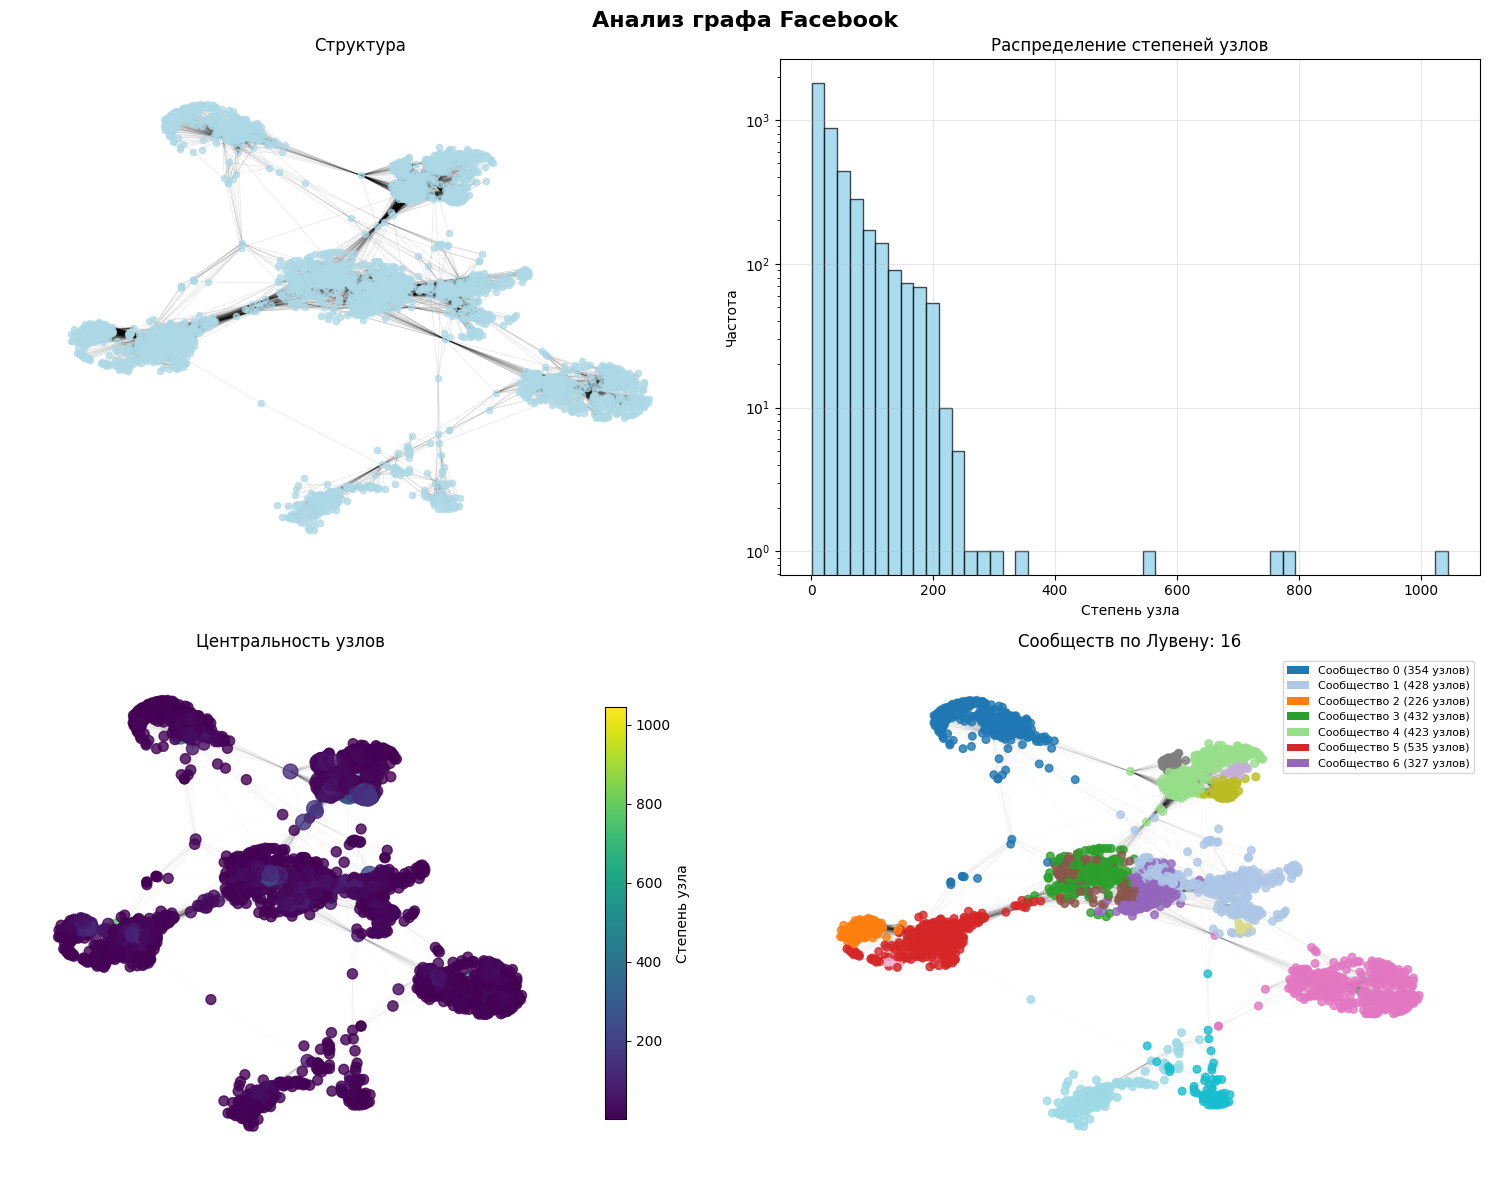

In [11]:
visualize_full_graph(G_combined)

### Выводы по визуализации
1. Структура графа (рис. 1): ярко выделены 5 крупных кластеров (облаков точек) и ещё 2 более мелких, но отдельных. Также на структуре выделяются узлы-брокеры (посредники) соединяющие между собой крупные кластеры.
2. Из 4039 узлов (рис. 2) только 26 имеют стеепень более 200 (местные "звёзды"). Они являются центральными в своих локальных сообществах (на рис. 3 выделены в желто-зелёном спектре). При этом больше половины узлов имеют степень менее 60, что указывает на среднестатистического пользователя Facebook или соцсетей в целом.
3. Алгоритм Лувена (рис. 4) выделил 16 сообществ, при этом были разделены даже те, которые визуально (рис.1) выглядят "монолитно". Наличие большего числа сообществ по сравнению с визуально наблюдаемыми кластерами (рис. 1) может указывать на наличие вложенных структур внутри крупных кластеров (например, различные социальные круги), либо же на несоответсвие геометрической близости на визуализации spring layout (рис. 1) и реальной плотностью связей